In [1]:
import os
import sys
import math
import random
import statistics
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import seaborn as sb
sb.set_style("whitegrid")

cb_palette = ['#377eb8', '#ff7f00', '#4daf4a',
              '#f781bf', '#a65628', '#984ea3',
              '#999999', '#e41a1c', '#dede00']
sb.color_palette(cb_palette)


bsfolder = '/home/gabriele/Desktop/BindingSite_docking_master/'
codelist = [line.rstrip() for line in open(bsfolder+'list_dimers_b4')]
chainlist = []
for code in codelist:
    chainlist.append(code+'_u1')
    chainlist.append(code+'_u2')

def load_resfile(file):
    res = {}
    for line in open(bsfolder+'results/'+file):
        code = line.split()[-1].split('/')[-1].split('_')[0]
        dockq = float(line.split()[1])
        if not code in res: res[code] = []
        res[code].append(dockq)
    return res

dockqs = {'Greal':load_resfile('res_Gdock1'),
          'G02505':load_resfile('res_Gdock2'), 'G025075':load_resfile('res_Gdock3'),
          'G0505':load_resfile('res_Gdock4'), 'G05075':load_resfile('res_Gdock5'),
          'GISP':load_resfile('res_Gdock6'), 'GSPP':load_resfile('res_Gdock7'),
          'Gdyn':load_resfile('res_Gdock8')}


/home/gabriele/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


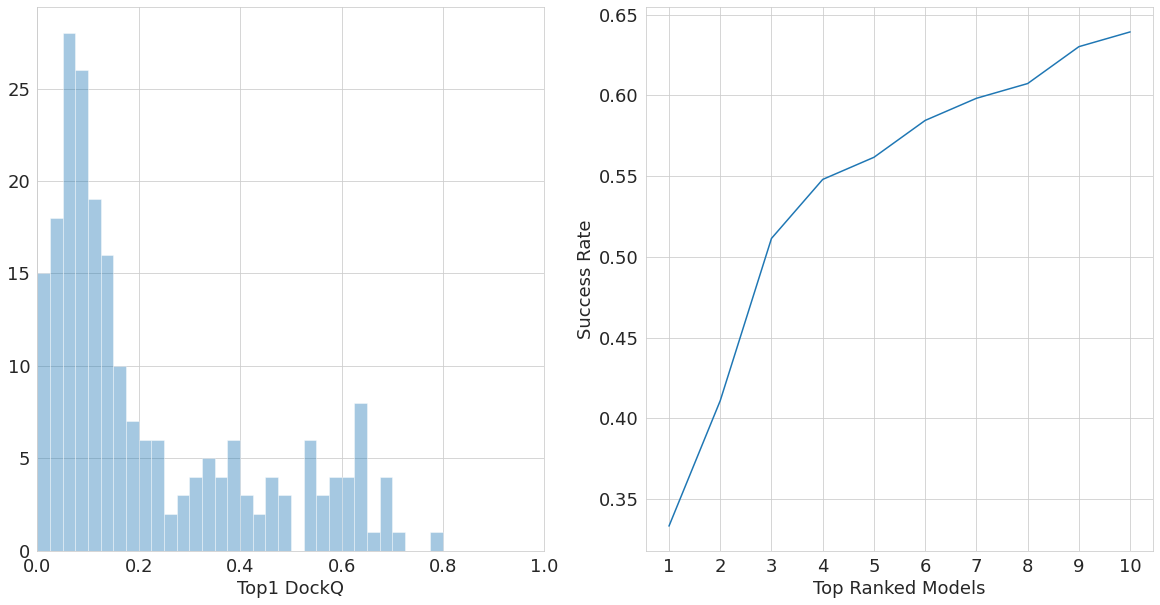

In [26]:
def get_firstmodel(key, lbl):
    results = [dockqs[key1][key][0] for key in dockqs[key1]]    
    return [results[key] for key in results]

def success_rate(runs):
    succ_rates = {'TopMod.':list(range(1,11))}
    for runkey in runs:
        for top in range(1,11):
            res = {key:max(dockqs[runkey][key][:top]) for key in dockqs[runkey]}
            success = [1 if res[key] >= 0.23 else 0 for key in res]
            if not runkey in succ_rates: succ_rates[runkey] = []
            succ_rates[runkey].append(sum(success)/len(success))

    succ_rates = pd.DataFrame(succ_rates)
    return succ_rates

lbl = 'Gramm DockQ'
results = [dockqs['Greal'][key][0] for key in dockqs['Greal']]
succ_rates = success_rate(['Greal'])

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sb.distplot(results, kde=False, bins=np.arange(0.0, 1.025, 0.025), ax=axes[0])
axes[0].set_xlabel("Top1 DockQ")
axes[0].set_xlim(0,1)

sb.lineplot(x='TopMod.', y='Greal', data=succ_rates, ax=axes[1])
axes[1].set_ylabel("Success Rate")
axes[1].set_xlabel("Top Ranked Models")
axes[1].set_xticks(np.arange(1,11))

fig.savefig(bsfolder+'pictures/pyrosettavsgramm_realBS.png')
plt.show()

No handles with labels found to put in legend.


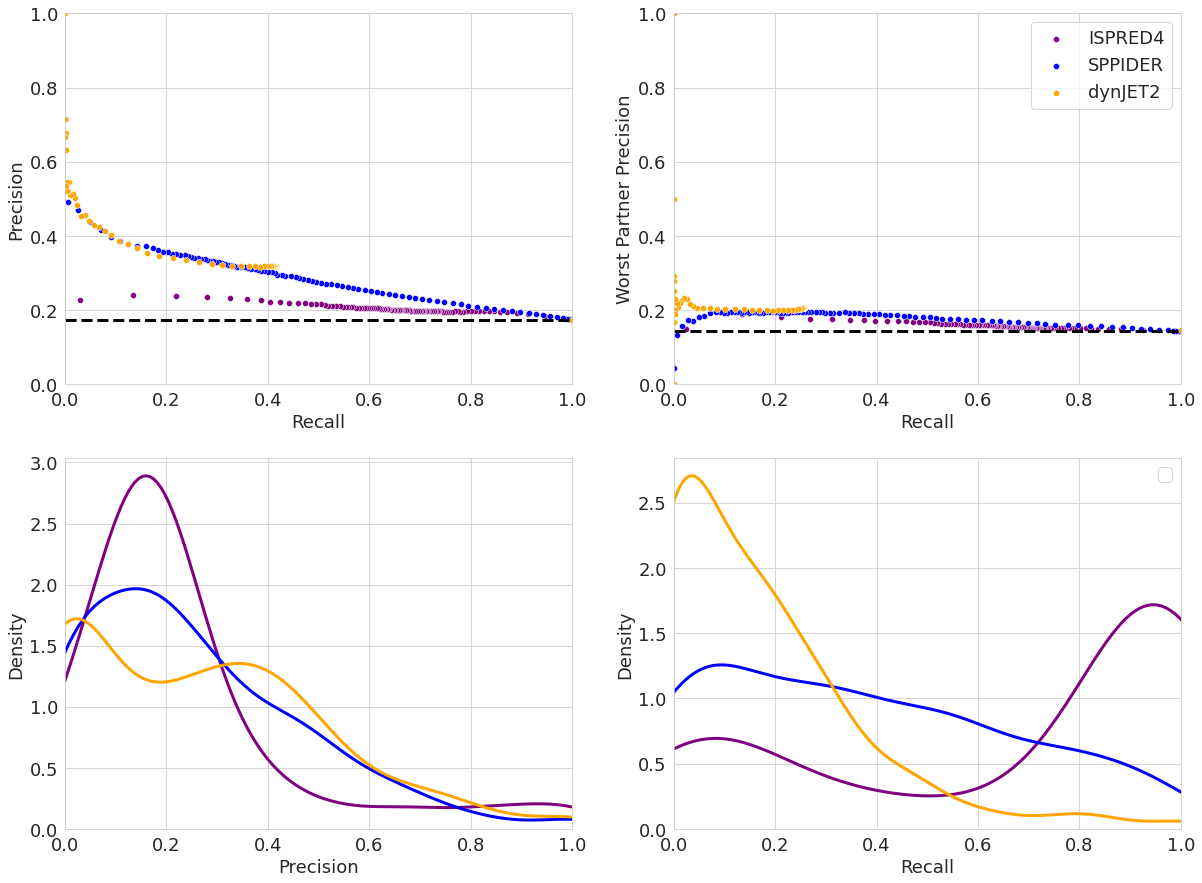

In [79]:
def get_thr(scores, thr):
    TP = FP = FN = TN = 0
    
    for pred, real in scores:
        if pred >= thr:
            if real == 1.0: TP += 1
            if real == 0.0: FP += 1
        if pred < thr:
            if real == 1.0: FN += 1
            if real == 0.0: TN += 1
                
    if TP+FN != 0: TPR = TP/(TP+FN)
    else: TPR = 0.0
    if TP+FP != 0: PPV = TP/(TP+FP)
    else: PPV = 0.0
    return TPR, PPV

def compute_auc_stats(scores):
    predscores = np.array(scores)
    predscores = predscores[:,0].flatten()
    realscores = np.array(scores)
    realscores = realscores[:,1].flatten()
    pPPV, pTPR, pTHR = precision_recall_curve(realscores, predscores)
    stats = {'pTPR':pTPR, 'pPPV':pPPV}
    return stats
    
def BSpred_stats(n,  label):
    allscores = []
    worstscores = []
    chainscores1 = []
    chainscores2 = []
    worststatsmap = {}
    splitworststats = {'PPV':[], 'TPR':[]}
    for code in chainlist:
        pdbcode = code[:4]
        labelfile = bsfolder+'data/formatted_labels/'+code+'.site'
        if not os.path.exists(labelfile): 
            print (labelfile, 'not found!')
            continue
        isp = [float(line.split()[n]) for line in open(labelfile)]
        ist = [float(line.split()[1]) for line in open(labelfile)]
        rsa = [float(line.split()[0]) for line in open(labelfile)]
        for lp, lt, acc in zip(isp, ist, rsa):
            if acc < 0.2: continue
            allscores.append([lp, lt])
            if '_u1' in code: chainscores1.append([lp, lt])
            else: chainscores2.append([lp, lt])
            
        if '_u2' in code:
            stats1 = compute_auc_stats(chainscores1)
            stats2 = compute_auc_stats(chainscores2)
            auc1 = auc(stats1['pTPR'], stats1['pPPV'])
            auc2 = auc(stats2['pTPR'], stats2['pPPV'])            
            if auc1 < auc2: 
                worstscores += chainscores1
                dimerscores = np.array(chainscores1)
                TPR, PPV = get_thr(dimerscores, 0.5)
                worststatsmap[pdbcode] = [TPR, PPV]
                splitworststats['PPV'].append(PPV)        
                splitworststats['TPR'].append(TPR)
            else:
                worstscores += chainscores2
                dimerscores = np.array(chainscores1)
                TPR, PPV = get_thr(dimerscores, 0.5)
                worststatsmap[pdbcode] = [TPR, PPV]
                splitworststats['PPV'].append(PPV)        
                splitworststats['TPR'].append(TPR)
            chainscores1 = []
            chainscores2 = []           
    
    allstats = compute_auc_stats(allscores)
    worststats = compute_auc_stats(worstscores)
    return allstats, worststats, splitworststats, worststatsmap

isp, isp_w, isp_split, isp_map = BSpred_stats(6, 'ISP')
spp, spp_w, spp_split, spp_map = BSpred_stats(7, 'SPP')
dyn, dyn_w, dyn_split, dyn_map = BSpred_stats(8, 'dyn')

auROC_isp = round(auc(isp['rFPR'], isp['rTPR']),2)
auROC_spp = round(auc(spp['rFPR'], spp['rTPR']),2)
auROC_dyn = round(auc(dyn['rFPR'], dyn['rTPR']),2)
auPR_isp = round(auc(isp['pTPR'], isp['pPPV']),2)
auPR_spp = round(auc(spp['pTPR'], spp['pPPV']),2)
auPR_dyn = round(auc(dyn['pTPR'], dyn['pPPV']),2)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

c = 0
sb.scatterplot(x='pTPR', y='pPPV', data=isp, color='purple', ax=axes[c][0])
sb.scatterplot(x='pTPR', y='pPPV', data=isp_w, color='purple', ax=axes[c][1], label='ISPRED4')
sb.scatterplot(x='pTPR', y='pPPV', data=spp, color='blue', ax=axes[c][0])
sb.scatterplot(x='pTPR', y='pPPV', data=spp_w, color='blue', ax=axes[c][1], label='SPPIDER')
sb.scatterplot(x='pTPR', y='pPPV', data=dyn, color='orange', ax=axes[c][0])
sb.scatterplot(x='pTPR', y='pPPV', data=dyn_w, color='orange', ax=axes[c][1], label='dynJET2')
axes[c][0].plot([0, 1], [isp['pPPV'][0], isp['pPPV'][0]], ls="--", lw='3', color='black')
axes[c][1].plot([0, 1], [isp_w['pPPV'][0], isp_w['pPPV'][0]], ls="--", lw='3', color='black')
axes[c][0].set_xlim(0,1)
axes[c][0].set_ylim(0,1)
axes[c][0].set_xlabel('Recall')
axes[c][0].set_ylabel('Precision')
axes[c][1].set_xlim(0,1)
axes[c][1].set_ylim(0,1)
axes[c][1].set_xlabel('Recall')
axes[c][1].set_ylabel('Worst Partner Precision')

c = 1
sb.kdeplot(x='PPV', data=isp_split, color='purple', lw='3', ax=axes[c][0])
sb.kdeplot(x='PPV', data=spp_split, color='blue', lw='3', ax=axes[c][0])
sb.kdeplot(x='PPV', data=dyn_split, color='orange', lw='3', ax=axes[c][0])
axes[c][0].set_xlabel('Precision')
axes[c][0].set_xlim(0,1)

sb.kdeplot(x='TPR', data=isp_split, color='purple', lw='3', ax=axes[c][1])
sb.kdeplot(x='TPR', data=spp_split, color='blue', lw='3', ax=axes[c][1])
sb.kdeplot(x='TPR', data=dyn_split, color='orange', lw='3', ax=axes[c][1])
axes[c][1].set_xlabel('Recall')
axes[c][1].set_xlim(0,1)
plt.legend()
plt.show()

# 1 - PR-curve, whole dataset
# 2 - PR curve, worst-predicted-interface partner in each dimer
# 3 - distribution of F1 calculated for single worst-predicted-interface partner in each dimer of the set

(0.0, 1.0)

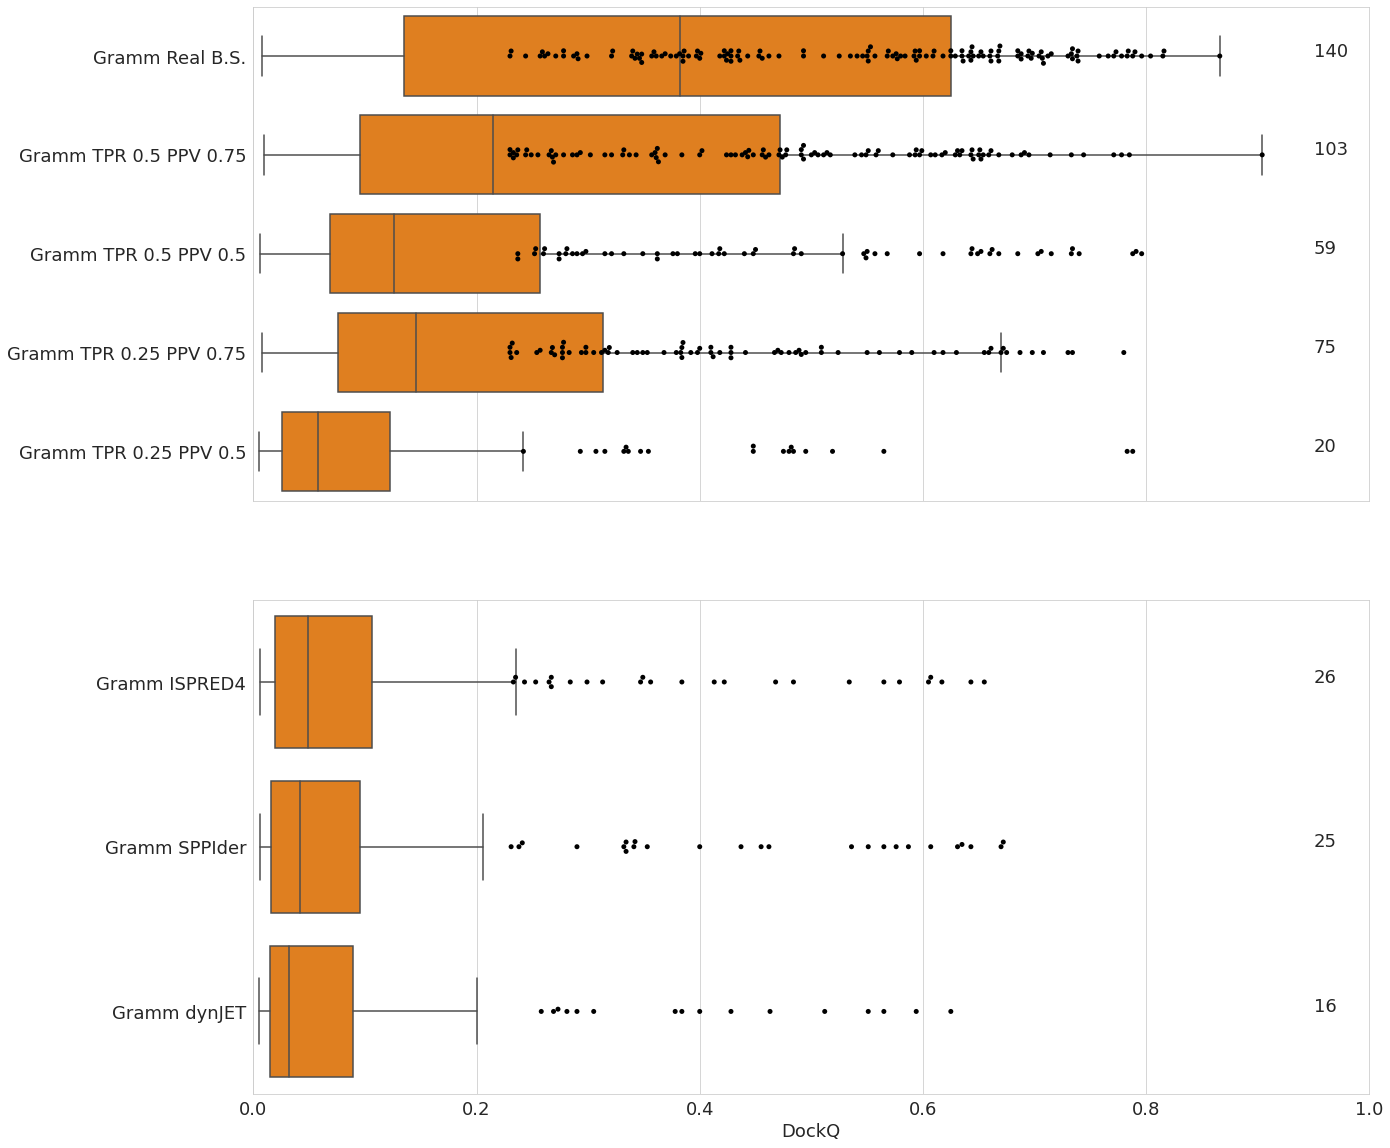

In [63]:
name_refine = { 
    'Greal':'Gramm Real B.S.',
    'G025075':'Gramm TPR 0.25 PPV 0.75',
    'G02505':'Gramm TPR 0.25 PPV 0.5',
    'G05075':'Gramm TPR 0.5 PPV 0.75',
    'G0505':'Gramm TPR 0.5 PPV 0.5',
    'GISP':'Gramm ISPRED4',
    'GSPP':'Gramm SPPIder',
    'Gr4s':'Gramm Rate4Site',
    'Gdyn':'Gramm dynJET'}

def compare_runs_top1(runs, top1=True):
    countdic = {}
    bardic = {'DockQ':[], 'Setup':[]}
    swarmdic = {'DockQ':[], 'Setup':[]}
    for run in runs:
        if top1:
            countdic[run] = len([1 for code in dockqs[run] if dockqs[run][code][0] >= 0.23])
            for code in dockqs[run]:
                bardic['DockQ'].append(dockqs[run][code][0])
                bardic['Setup'].append(name_refine[run])
                if dockqs[run][code][0] >= 0.23: 
                    swarmdic['DockQ'].append(dockqs[run][code][0])
                    swarmdic['Setup'].append(name_refine[run])
            if not name_refine[run] in swarmdic['Setup']:
                swarmdic['DockQ'].append(-1)
                swarmdic['Setup'].append(name_refine[run])
        else:
            countdic[run] = len([1 for code in dockqs[run] if max(dockqs[run][code]) >= 0.23])
            for code in dockqs[run]:
                bardic['DockQ'].append(max(dockqs[run][code]))
                bardic['Setup'].append(name_refine[run])
                if max(dockqs[run][code]) >= 0.23: 
                    swarmdic['DockQ'].append(max(dockqs[run][code]))
                    swarmdic['Setup'].append(name_refine[run])
            if not name_refine[run] in swarmdic['Setup']:
                swarmdic['DockQ'].append(-1)
                swarmdic['Setup'].append(name_refine[run])
    return bardic, swarmdic, countdic

fig, axes = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

randomized_runs = ['Greal', 'G05075', 'G0505', 'G025075', 'G02505']
bardic, swarmdic, countdic = compare_runs_top1(randomized_runs, top1=False)
palette = {setup:'#377eb8' if 'PyRosetta' in setup else '#ff7f00'\
           for setup in set(bardic['Setup'])}

sb.swarmplot(x='DockQ', y='Setup', data=swarmdic, color='Black', size=5, ax=axes[0])
sb.boxplot(x='DockQ', y='Setup', data=bardic, showfliers=False, palette=palette, ax=axes[0])
for n, lbl in enumerate(countdic): axes[0].text(x=0.95, y=n, s=countdic[lbl])
axes[0].set_xticks(np.arange(0, 1.1, 0.2))

randomized_runs = ['GISP', 'GSPP', 'Gdyn']
bardic, swarmdic, countdic = compare_runs_top1(randomized_runs, top1=False)
palette = {setup:'#377eb8' if 'PyRosetta' in setup else '#ff7f00'\
           for setup in set(bardic['Setup'])}

sb.swarmplot(x='DockQ', y='Setup', data=swarmdic, color='Black', size=5, ax=axes[1])
sb.boxplot(x='DockQ', y='Setup', data=bardic, showfliers=False, palette=palette, ax=axes[1])
for n, lbl in enumerate(countdic): axes[1].text(x=0.95, y=n, s=countdic[lbl])
axes[1].set_xticks(np.arange(0, 1.1, 0.2))
axes[1].set_xlabel('DockQ')
axes[1].set_xlim(0,1)


FileNotFoundError: [Errno 2] No such file or directory: '/home/gabriele/Desktop/BindingSite_docking_master/results/Greal_rmsds'

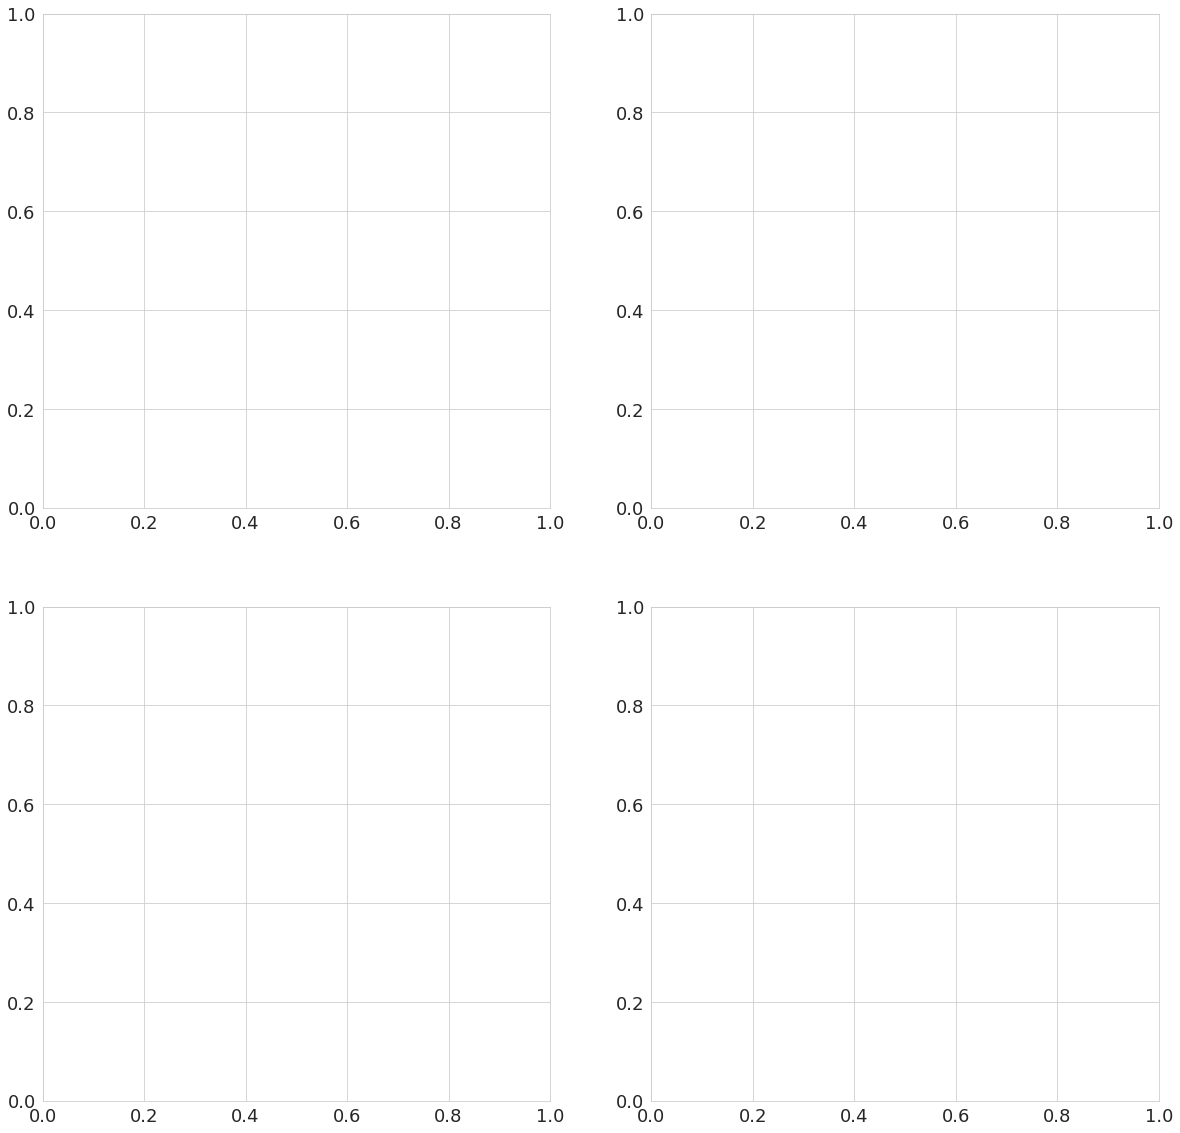

In [62]:
def rmsd_scattering():
    rundic = {}
    runs = ['Greal', 'Preal', 'Gr4s', 'PSPP']
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    for run in runs: 
        rmsds = {}
        for line in open(bsfolder+'results/'+run+'_rmsds'):
            code = line.split()[0]
            rmsd = float(line.split()[-1])
            if not code in rmsds: rmsds[code] = []
            rmsds[code].append(rmsd)
        rundic[run+'_max'] = [max(rmsds[key]) for key in rmsds]
        rundic[run+'_min'] = [min(rmsds[key]) for key in rmsds]
        rundic[run+'_all'] = []
        for key in rmsds: rundic[run+'_all'].extend(rmsds[key])
    
    i = j = 0
    sb.kdeplot(rundic['Greal_max'], label='MaxRMSDs', ax=axes[i][j])
    sb.kdeplot(rundic['Greal_min'], label='MinRMSDs', ax=axes[i][j])
    sb.kdeplot(rundic['Greal_all'], label='AllRMSDs', ax=axes[i][j])
    axes[i][j].set_xlim(0,80)
    axes[i][j].set_ylim(0,0.7)
    axes[i][j].set_title('Gramm real B.S.')
    i = 0
    j = 1
    sb.kdeplot(rundic['Preal_max'], label='MaxRMSDs', ax=axes[i][j])
    sb.kdeplot(rundic['Preal_min'], label='MinRMSDs', ax=axes[i][j])
    sb.kdeplot(rundic['Preal_all'], label='AllRMSDs', ax=axes[i][j])
    axes[i][j].set_xlim(0,200)
    axes[i][j].set_ylim(0,0.1)
    axes[i][j].set_title('Pyros real B.S.')
    axes[i][j].legend()
    i = 1
    j = 0
    sb.kdeplot(rundic['Gr4s_max'], label='MaxRMSDs', ax=axes[i][j])
    sb.kdeplot(rundic['Gr4s_min'], label='MinRMSDs', ax=axes[i][j])
    sb.kdeplot(rundic['Gr4s_all'], label='AllRMSDs', ax=axes[i][j])
    axes[i][j].set_xlim(0,80)
    axes[i][j].set_ylim(0,0.7)
    axes[i][j].set_title('Gramm Rate4Site B.S.')
    axes[i][j].set_xlabel("Ångström")
    i = j = 1
    sb.kdeplot(rundic['PSPP_max'], label='MaxRMSDs', ax=axes[i][j])
    sb.kdeplot(rundic['PSPP_min'], label='MinRMSDs', ax=axes[i][j])
    sb.kdeplot(rundic['PSPP_all'], label='AllRMSDs', ax=axes[i][j])
    axes[i][j].set_xlim(0,200)
    axes[i][j].set_ylim(0,0.1)
    axes[i][j].set_title('Pyros SPPIder B.S.')
    axes[i][j].set_xlabel("Ångström")
              
rmsd_scattering()
